In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly = 189
#funcs = os.listdir(f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}')
#funcs = [i for i in funcs if 'func' in i]
#for func in ['func_7']:#funcs:
func = 'func_0'
print(func)
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'
brain_file = os.path.join(load_directory, 'functional_channel_2_moco_zscore_highpass.h5')
with h5py.File(brain_file, 'r') as hf:
    brain = hf['data'][:]
#brain = np.asarray(nib.load(brain_file).get_fdata().squeeze(), dtype='float32')

func_0


In [3]:
brain.shape

(127, 32, 14, 6156)

In [4]:
#brain_smooth = scipy.ndimage.gaussian_filter(brain, sigma=(1,1,1),truncate=1)
temporal_mean = np.mean(brain,axis=-1)
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000    

#brain_norm = brain / np.mean(brain,axis=-1)[:,:,:,np.newaxis]
timestep = np.diff(timestamps[:,0])[0] #is units of ms
xs = np.arange(-60*1000,60*1000,timestep)  

Trying to load timestamp data from hdf5 file.
Success.


In [59]:
xs = np.arange(-65*1000,65*1000,timestep)  
len(xs)

1310

In [58]:
cc = scipy.signal.correlate(brain[i,j,z,:], fictrac_interp)[5500:-5501]
cc.shape

(1310,)

In [60]:
##########################
### CORRELATION AND CC ###
##########################

z=0
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY']
corrs = {}
peak_times = {}
for behavior in behaviors:

    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    corrs[behavior] = np.zeros((brain.shape[0],brain.shape[1],brain.shape[2]))
    peak_times[behavior] = np.zeros((brain.shape[0],brain.shape[1],brain.shape[2]))
    for i in tqdm.tqdm(range(brain.shape[0])):
        for j in range(brain.shape[1]):
            for z in range(brain.shape[2]):
                corrs[behavior][i,j,z] = scipy.stats.pearsonr(fictrac_interp, brain[i,j,z,:])[0]
                cc = scipy.signal.correlate(brain[i,j,z,:], fictrac_interp)[5500:-5501]
                peak_times[behavior][i,j,z] = xs[np.argmax(cc)]

norm_min = 0
norm_max = max(np.max(corrs['dRotLabZneg']), np.max(corrs['dRotLabZpos']), np.max(corrs['dRotLabY']))
colors1 = Normalize(norm_min, norm_max)(corrs['dRotLabZneg'])
colors2 = Normalize(norm_min, norm_max)(corrs['dRotLabZpos'])
colors3 = Normalize(norm_min, norm_max)(corrs['dRotLabY'])
to_plot = np.stack((colors1,colors2,colors3),axis=2)
to_plot = np.swapaxes(to_plot,0,1)


100%|██████████| 127/127 [00:45<00:00,  2.79it/s]


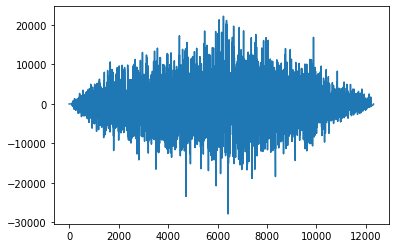

In [29]:
plt.plot(cc)

In [27]:
np.max(corrs['dRotLabY'])

0.1921263626569601

In [16]:
to_plot = np.swapaxes(to_plot,2,3)

In [20]:
to_plot = np.max(to_plot,axis=2)

In [21]:
to_plot.shape

(32, 127, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


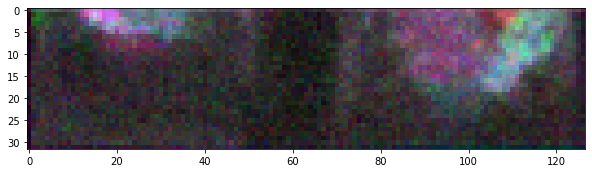

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


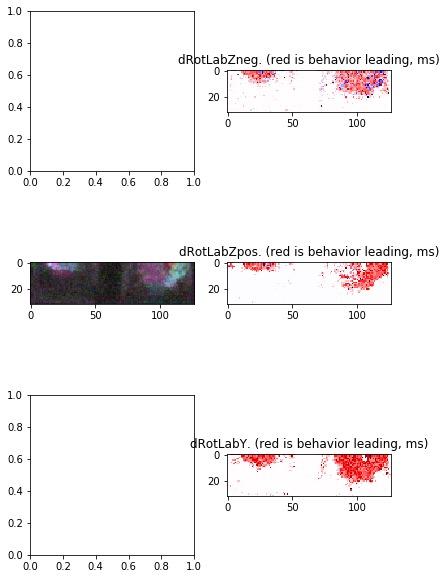

In [62]:

plt.figure(figsize=(10,10))

# plot first column
for i in [1,2,3]:
    plt.subplot(3,3,i*3-2)#1,4,7

#     if i==1:
#         plt.imshow(temporal_mean.T,cmap='Greys_r')
#         plt.title('fly:{}; func:{}; max corr:\n{:.02f}'.format(fly, func, norm_max))

    if i==2:
        plt.imshow(np.max(to_plot,axis=3))

#     if i==3:
#         alpha = np.zeros(to_plot.shape[:2])
#         alpha[np.where(np.max(to_plot,axis=-1)>.2)]=1 #.2 is on the normalized data so top 20% voxels will be shown
#         signals_alpha = np.concatenate((to_plot,alpha[..., np.newaxis]),axis=-1)
#         #plt.imshow(temporal_mean.T,cmap='Greys_r')
#         plt.imshow(signals_alpha)

for i, behavior in enumerate(behaviors):
    corr_thresh = .05
    plt.subplot(3,3,(i*3)+2)#2,5,8
    peak_times_mask = peak_times[behavior].copy()
    peak_times_mask[np.where(corrs[behavior]<corr_thresh)] = 0
    maxs = np.max(peak_times_mask,axis=2)
    mins = np.min(peak_times_mask,axis=2)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    plt.imshow(maxs.T,vmin=-1000,vmax=1000,cmap='seismic')
    #plt.colorbar()
    plt.title(f'{behavior}. (red is behavior leading, ms)')

#     corr_thresh = .2
#     plt.subplot(3,3,(i*3)+3)#3,6,9
#     peak_times_mask = peak_times[behavior].copy()
#     peak_times_mask[np.where(corrs[behavior]<corr_thresh)] = 0
#     plt.imshow(peak_times_mask.T,vmin=-300,vmax=300,cmap='seismic')

#     plt.subplots_adjust(wspace=0,hspace=0)
#     save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
#     timestr = time.strftime("%Y%m%d-%H%M%S")
#     fname = os.path.join(save_path, timestr)
#     plt.savefig(fname,dpi=300,bbox_inches='tight')

In [42]:
peak_times_mask.shape

(127, 32, 14)

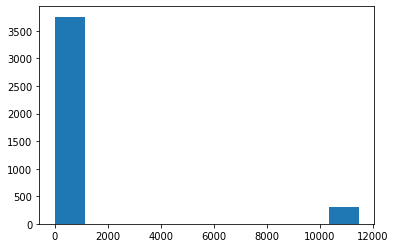

In [46]:
plt.hist(maxs.flatten());